# INM707 Coursework Task 3
### Aaron Mir (Student Number: 160001207)
## DDPG Implementation on Lunar Lander Environment

In [ ]:
##--------------------Coding References---------------------## 
# Percentage of borrowed code: 5% - DDPG implementation inspired by Spinning Up implementation
# [1] Spinning Up (2020) DDPG, 
# Available at: https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/ddpg (Accessed: 29th March 2021).

In [1]:
import gym
import numpy as np 
from ddpg.ddpg import ddpg_train_val, test_agent, ActorCritic
import torch
import torch.optim as optim
import scipy 
import pickle
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import io
import base64
import time
import glob

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Gym Version: {gym.__version__}")
print(f"Scipy Version: {scipy.__version__}")

Python: 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
Numpy Version: 1.19.5
PyTorch Version: 1.7.1+cu110
Gym Version: 0.18.0
Scipy Version: 1.6.0


In [2]:
# TO RUN A TEST, RUNNING THE SETUP CELLS AT THE BEGINNING OF THE NOTEBOOK ANS THEN RUN THE TEST CELLS AT THE BOTTOM OF THE NOTEBOOK  

***
## Lunar Lander

The environment is defined as follows:

- The goal is to land the lunar module on the moon between the flags without crashing. The state vector is eight dimensional and contains: [x_pos, y_pos, x_vel, y_vel, lander_angle, lander_angular_vel, leftleg ground_contact_flag, right_leg_ground_contact_flag]. 

- The landing pad coordinates are always at 0, 0 and are the first two numbers in the state vector.

- There are two possible actions which take float values [main engine, left-right engines].

    - Main engine: from -1 to 0, the engine is off and between 0 and +1, the engine throttle is from 50% to 100% power. The engine can't work with less than 50% power.

    - Left-right engines: from -1 to -0.5, the left engine is on. From +0.5 to +1, the right engine is on. Between -0.5 and 0.5, both engines are off.
    
- The agent receives +100 to +140 reward for moving from the top of the screen to the landing pad, a -100 penalty for crashing into the landing pad and an additional +100 reward for landing on the pad at rest. Each leg that is in contact with the ground is +10. Firing the main engine is -0.3 penalty for each frame it is fired in. 

- The environment is considered solved when the agent gets +200 reward.

- Episodes end whenever the agent crashes or comes to a rest.

***

## Setup

In [6]:
def make_env(env_name, seed=None):  # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

In [7]:
def save_checkpoint(state, filename):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, q_optimizer, policy_optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    q_optimizer.load_state_dict(checkpoint['q-optimizer'])

## Investigating Gamma Variation 

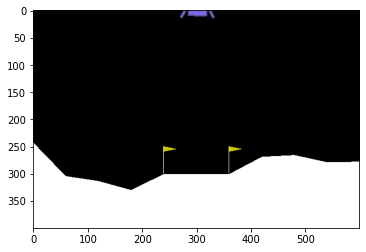

In [ ]:
env = make_env('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, action_shape = env.observation_space.shape, env.action_space.shape
print('State shape: {}'.format(state_shape))
print('Action shape: {}'.format(action_shape))
env.close()

In [5]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.99 p_lr 0.001 q_lr 0.001
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.99, polyak=0.995, 
        policy_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -216, Training Average Length: 96, Val Average Reward: -154, Val Average Length: 1000
Epoch: 2, Training Average Reward: -229, Training Average Length: 144, Val Average Reward: -104, Val Average Length: 575
Epoch: 3, Training Average Reward: -178, Training Average Length: 154, Val Average Reward: 46, Val Average Length: 271
Epoch: 4, Training Average Reward: -15, Training Average Length: 635, Val Average Reward: -19, Val Average Length: 866
Epoch: 5, Training Average Reward: -20, Training Average Length: 789, Val Average Reward: -27, Val Average Length: 915
Epoch: 6, Training Average Reward: -22, Training Average Length: 832, Val Average Reward: -4, Val Average Length: 659
Epoch: 7, Training Average Reward: -35, Training Average Length: 832, Val Average Reward: -106, Val Average Length: 582
Epoch: 8, Training Average Reward: -71, Training Average Length: 545, Val Average Reward: -68, Val Average Length: 906
Epoch: 9, Training Average Reward: -159, Tra

In [6]:
checkpoint = {                      # gamma 0.99 p_lr 0.001 q_lr 0.001
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma099qlr0001plr0001.pth.tar')
# test results from gamma=0.99
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000)
# saving the results for rewards per test episode 100 epochs, gamma 0.99 qlr 0.0001 plr 0.0001                   
pickle.dump(ep_rews, open('results/task3/gamma_diff/ep_rews_trained_gamma099qlr0001plr0001'+'.ddpg', 'wb'), -1)         

=> Saving checkpoint


In [5]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.995 p_lr 0.001 q_lr 0.001
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.995, polyak=0.995, 
        policy_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -222, Training Average Length: 106, Val Average Reward: -113, Val Average Length: 217
Epoch: 2, Training Average Reward: -200, Training Average Length: 145, Val Average Reward: -36, Val Average Length: 390
Epoch: 3, Training Average Reward: -196, Training Average Length: 162, Val Average Reward: -50, Val Average Length: 583
Epoch: 4, Training Average Reward: -4, Training Average Length: 820, Val Average Reward: 8, Val Average Length: 1000
Epoch: 5, Training Average Reward: -40, Training Average Length: 794, Val Average Reward: -9, Val Average Length: 1000
Epoch: 6, Training Average Reward: -128, Training Average Length: 447, Val Average Reward: -115, Val Average Length: 412
Epoch: 7, Training Average Reward: -96, Training Average Length: 260, Val Average Reward: -96, Val Average Length: 224
Epoch: 8, Training Average Reward: -121, Training Average Length: 389, Val Average Reward: -180, Val Average Length: 128
Epoch: 9, Training Average Reward: -179, T

In [6]:
checkpoint = {
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma0995qlr0001plr0001.pth.tar')
# test results from gamma 0.995
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000) 
 # saving the results for rewards per test episode 85 epochs, gamma 0.995 qlr 0.001 plr 0.001                     
pickle.dump(ep_rews, open('results/task3/gamma_diff/ep_rews_trained_gamma0995qlr0001plr0001'+'.ddpg', 'wb'), -1)        

=> Saving checkpoint


In [5]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.9 p_lr 0.001 q_lr 0.001
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.9, polyak=0.995, 
        policy_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -228, Training Average Length: 116, Val Average Reward: -233, Val Average Length: 406
Epoch: 2, Training Average Reward: -225, Training Average Length: 102, Val Average Reward: -309, Val Average Length: 434
Epoch: 3, Training Average Reward: -218, Training Average Length: 162, Val Average Reward: -87, Val Average Length: 517
Epoch: 4, Training Average Reward: -227, Training Average Length: 467, Val Average Reward: -233, Val Average Length: 493
Epoch: 5, Training Average Reward: -170, Training Average Length: 452, Val Average Reward: -157, Val Average Length: 541
Epoch: 6, Training Average Reward: -78, Training Average Length: 750, Val Average Reward: -66, Val Average Length: 684
Epoch: 7, Training Average Reward: -73, Training Average Length: 426, Val Average Reward: -97, Val Average Length: 764
Epoch: 8, Training Average Reward: -170, Training Average Length: 506, Val Average Reward: -159, Val Average Length: 682
Epoch: 9, Training Average Reward: -1

In [6]:
checkpoint = {              # gamma 0.9 p_lr 0.001 q_lr 0.001
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma09qlr0001plr0001.pth.tar')
# test results from gamma = 0.9
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000)  
# saving the results for rewards per test episode 100 epochs, gamma 0.9 qlr 0.001 plr 0.001                  
pickle.dump(ep_rews, open('results/task3/gamma_diff/ep_rews_trained_gamma09qlr0001plr0001'+'.ddpg', 'wb'), -1)         

=> Saving checkpoint


In [7]:
# # loading the results for gamma variation graph
# ep_rews_trained_gamma09qlr0001plr0001 = pickle.load(open('results/task3/gamma_diff/ep_rews_trained_gamma09qlr0001plr0001'+'.ddpg', 'rb'))
# ep_rews_trained_gamma099qlr0001plr0001 = pickle.load(open('results/task3/gamma_diff/ep_rews_trained_gamma099qlr0001plr0001'+'.ddpg', 'rb'))         
# ep_rews_trained_gamma0995qlr0001plr0001 = pickle.load(open('results/task3/gamma_diff/ep_rews_trained_gamma0995qlr0001plr0001'+'.ddpg', 'rb')) 

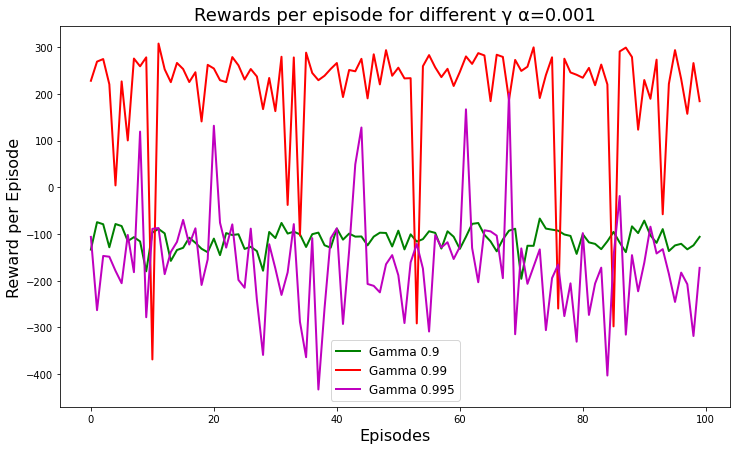

In [8]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma09qlr0001plr0001, 'g', linewidth=2.0, label='Gamma 0.9')
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma099qlr0001plr0001, 'r', linewidth=2.0, label='Gamma 0.99')
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma0995qlr0001plr0001, 'm', linewidth=2.0, label='Gamma 0.995')
plt.title('Rewards per episode for different γ α=0.001', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Reward per Episode', fontsize=16)
plt.legend(fontsize=12, loc='best')
# plt.savefig('results/task3/gamma_diff/Different_gamma')
plt.show()

## Investigating Learning Rate Variation 

In [5]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.99 p_lr 0.01 q_lr 0.01
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.99, polyak=0.995, 
        policy_lr=1e-2, q_lr=1e-2, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -229, Training Average Length: 103, Val Average Reward: -32, Val Average Length: 1000
Epoch: 2, Training Average Reward: -190, Training Average Length: 109, Val Average Reward: -0, Val Average Length: 215
Epoch: 3, Training Average Reward: -158, Training Average Length: 115, Val Average Reward: -43, Val Average Length: 1000
Epoch: 4, Training Average Reward: -163, Training Average Length: 692, Val Average Reward: -115, Val Average Length: 880
Epoch: 5, Training Average Reward: -57, Training Average Length: 1000, Val Average Reward: -68, Val Average Length: 1000
Epoch: 6, Training Average Reward: -68, Training Average Length: 1000, Val Average Reward: -55, Val Average Length: 1000
Epoch: 7, Training Average Reward: -51, Training Average Length: 1000, Val Average Reward: -56, Val Average Length: 1000
Epoch: 8, Training Average Reward: -72, Training Average Length: 763, Val Average Reward: 31, Val Average Length: 394
Epoch: 9, Training Average Reward: -1

In [6]:
checkpoint = {
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma099qlr001plr001.pth.tar')
# test results from lr = 0.01
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000)
# saving the results for rewards per test episode                    
pickle.dump(ep_rews, open('results/task3/lr_diff/ep_rews_trained_gamma099qlr001plr001'+'.ddpg', 'wb'), -1)  

=> Saving checkpoint


In [5]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.99 p_lr 0.05 q_lr 0.05
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.99, polyak=0.995, 
        policy_lr=5e-2, q_lr=5e-2, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -240, Training Average Length: 104, Val Average Reward: -953, Val Average Length: 75
Epoch: 2, Training Average Reward: -206, Training Average Length: 103, Val Average Reward: -1085, Val Average Length: 84
Epoch: 3, Training Average Reward: -659, Training Average Length: 93, Val Average Reward: -983, Val Average Length: 80
Epoch: 4, Training Average Reward: -1182, Training Average Length: 93, Val Average Reward: -803, Val Average Length: 68
Epoch: 5, Training Average Reward: -1012, Training Average Length: 84, Val Average Reward: -1018, Val Average Length: 81
Epoch: 6, Training Average Reward: -1026, Training Average Length: 83, Val Average Reward: -1058, Val Average Length: 82
Epoch: 7, Training Average Reward: -1203, Training Average Length: 95, Val Average Reward: -1101, Val Average Length: 89
Epoch: 8, Training Average Reward: -1180, Training Average Length: 94, Val Average Reward: -930, Val Average Length: 77
Epoch: 9, Training Average Reward: -1

In [6]:
checkpoint = {
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma099qlr005plr005.pth.tar')
# test results from lr = 0.05
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000)
# saving the results for rewards per test episode
pickle.dump(ep_rews, open('results/task3/lr_diff/ep_rews_trained_gamma099qlr005plr005'+'.ddpg', 'wb'), -1)  

=> Saving checkpoint


In [6]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.99 p_lr 0.1 q_lr 0.1
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.99, polyak=0.995, 
        policy_lr=1e-1, q_lr=1e-1, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -199, Training Average Length: 107, Val Average Reward: -970, Val Average Length: 81
Epoch: 2, Training Average Reward: -211, Training Average Length: 104, Val Average Reward: -1030, Val Average Length: 81
Epoch: 3, Training Average Reward: -684, Training Average Length: 98, Val Average Reward: -970, Val Average Length: 79
Epoch: 4, Training Average Reward: -1098, Training Average Length: 89, Val Average Reward: -1059, Val Average Length: 88
Epoch: 5, Training Average Reward: -1070, Training Average Length: 86, Val Average Reward: -894, Val Average Length: 72
Epoch: 6, Training Average Reward: -1026, Training Average Length: 84, Val Average Reward: -1088, Val Average Length: 86
Epoch: 7, Training Average Reward: -1112, Training Average Length: 89, Val Average Reward: -1336, Val Average Length: 98
Epoch: 8, Training Average Reward: -1063, Training Average Length: 88, Val Average Reward: -1385, Val Average Length: 104
Epoch: 9, Training Average Reward: 

In [7]:
checkpoint = {
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma099qlr01plr01.pth.tar')
# test results from lr = 0.1
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000)                 
pickle.dump(ep_rews, open('results/task3/lr_diff/ep_rews_trained_gamma099qlr01plr01'+'.ddpg', 'wb'), -1) 
# saving the results for rewards per test episode

=> Saving checkpoint


In [5]:
env_name = 'LunarLanderContinuous-v2' # gamma 0.99 p_lr 0.5 q_lr 0.5
agent, q_optimizer, policy_optimizer, val_ep_rews_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=85, replay_size=int(1e6), gamma=0.99, polyak=0.995, 
        policy_lr=5e-1, q_lr=5e-1, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -185, Training Average Length: 108, Val Average Reward: -608, Val Average Length: 68
Epoch: 2, Training Average Reward: -221, Training Average Length: 128, Val Average Reward: -444, Val Average Length: 59
Epoch: 3, Training Average Reward: -408, Training Average Length: 84, Val Average Reward: -604, Val Average Length: 68
Epoch: 4, Training Average Reward: -528, Training Average Length: 65, Val Average Reward: -516, Val Average Length: 66
Epoch: 5, Training Average Reward: -568, Training Average Length: 68, Val Average Reward: -476, Val Average Length: 56
Epoch: 6, Training Average Reward: -580, Training Average Length: 69, Val Average Reward: -654, Val Average Length: 75
Epoch: 7, Training Average Reward: -585, Training Average Length: 69, Val Average Reward: -518, Val Average Length: 60
Epoch: 8, Training Average Reward: -535, Training Average Length: 65, Val Average Reward: -618, Val Average Length: 69
Epoch: 9, Training Average Reward: -555, Train

In [6]:
checkpoint = {
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma099qlr05plr05.pth.tar')
# test results from lr = 0.5
ep_rews, ep_lens, avg_test_ep_rews, avg_test_ep_lens = test_agent(env, agent, 100, 1000)
# saving the results for rewards per test episode                 
pickle.dump(ep_rews, open('results/task3/lr_diff/ep_rews_trained_gamma099qlr05plr05'+'.ddpg', 'wb'), -1) 

=> Saving checkpoint


In [2]:
# # loading the results for gamma variation graph
# ep_rews_trained_gamma099qlr0001plr0001 = pickle.load(open('results/task3/gamma_diff/ep_rews_trained_gamma099qlr0001plr0001'+'.ddpg', 'rb'))
# ep_rews_trained_gamma099qlr001plr001 = pickle.load(open('results/task3/lr_diff/ep_rews_trained_gamma099qlr001plr001'+'.ddpg', 'rb'))
# ep_rews_trained_gamma099qlr005plr005 = pickle.load(open('results/task3/lr_diff/ep_rews_trained_gamma099qlr005plr005'+'.ddpg', 'rb'))
# ep_rews_trained_gamma099qlr01plr01 = pickle.load(open('results/task3/lr_diff/ep_rews_trained_gamma099qlr01plr01'+'.ddpg', 'rb'))         
# ep_rews_trained_gamma099qlr05plr05 = pickle.load(open('results/task3/lr_diff/ep_rews_trained_gamma099qlr05plr05'+'.ddpg', 'rb')) 

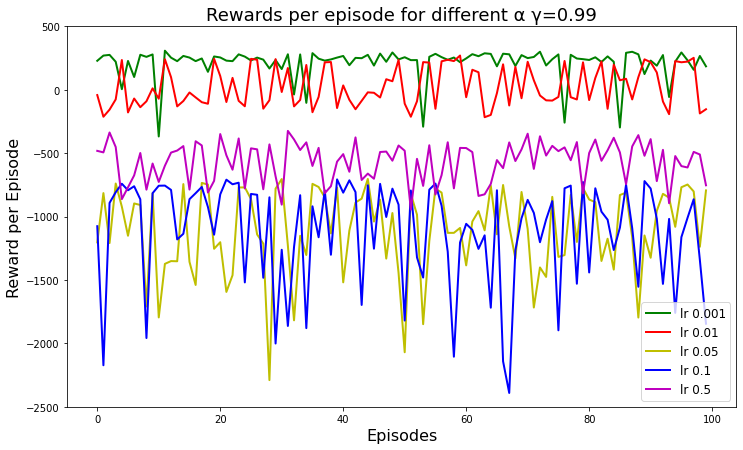

In [3]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma099qlr0001plr0001, 'g', linewidth=2.0, label='lr 0.001')
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma099qlr001plr001, 'r', linewidth=2.0, label='lr 0.01')
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma099qlr005plr005, 'y', linewidth=2.0, label='lr 0.05')
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma099qlr01plr01, 'b', linewidth=2.0, label='lr 0.1')
plt.plot(np.arange(0, 100, 1), ep_rews_trained_gamma099qlr05plr05, 'm', linewidth=2.0, label='lr 0.5')
plt.title('Rewards per episode for different α γ=0.99', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylim((-2500, 500))
plt.ylabel('Reward per Episode', fontsize=16)
plt.legend(fontsize=12, loc='best')
# plt.savefig('results/task3/lr_diff/Different_lr')
plt.show()

## TEST CELLS - Generating Animation of One Episode

In [8]:
def generate_animation(env, agent, save_dir):
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state, done, ep_rew, ep_len = env.reset(), False, 0, 0
    while not done:         # running through an episode
        state, reward, done, _ = env.step(agent.get_action(state, 0)) 
        ep_rew += reward
        ep_len += 1
    print('Reward: {}'.format(ep_rew))
    env.close()
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
env = make_env('LunarLanderContinuous-v2')
model = ActorCritic(env.observation_space, env.action_space).to(DEVICE)    
# model
q_optimizer = optim.Adam(model.q.parameters(), lr=0.001)                   
# optimizers
policy_optimizer = optim.Adam(model.policy.parameters(), lr=0.001)
checkpoint = torch.load('models/trained_gamma099qlr0001plr0001.pth.tar')   
# loading trained gamma 0.99 p_lr 0.001 q_lr 0.001 model
load_checkpoint(checkpoint, model, q_optimizer, policy_optimizer)

=> Loading checkpoint


In [7]:
env_name = 'LunarLanderContinuous-v2' 
save_dir='results/task3/animation'            
# animation of learned policy will pop up
env = gym.make(env_name)
generate_animation(env, model, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)             
# video file is in the directory if not working on notebook

Reward: 259.23149544560465
